# Проект: Прогноз оттока клиентов

## Описание

Сеть фитнес-центров разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Необходимо провести анализ и подготовить план действий по удержанию клиентов.

* построить модель прогнозирования оттока клиентов на уровне следующего месяца;
* сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* проанализировать основные признаки, наиболее сильно влияющие на отток;
* сформулировать выводы и разработать рекомендации по повышению качества работы с клиентами:

    1) выделить целевые группы клиентов;

    2) предложить меры по снижению оттока;

    3) определить другие особенности взаимодействия с клиентами.

## Импорт данных

In [1]:
# импорт библиотек
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
#!pip install -U seaborn

In [3]:
# импорт данных
churn = pd.read_csv('/datasets/gym_churn.csv')

# приведем названия столбцов к нижнему регичтру
churn.columns = churn.columns.str.lower()

churn.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Данные успешно импортированы.

## Исследовательский анализ данных (EDA)

Напишем функцию, выводящую сводную информацию о таблице, количество пропусков и дубликатов, а также описательную статистику по каждому столбцу (средние значения, стандартные отклонения и др).

In [4]:
def info(data):
    print('Информация о таблице')
    display(data.info())
    print('Размер таблицы')
    display(data.shape)
    print('Количество пропусков')
    display(data.isnull().sum())
    print('Количество дубликатов')
    display(data.duplicated().sum())
    print('Описательная статистика')
    display(data.describe())

In [5]:
info(churn)

Информация о таблице
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
near_location                        4000 non-null int64
partner                              4000 non-null int64
promo_friends                        4000 non-null int64
phone                                4000 non-null int64
contract_period                      4000 non-null int64
group_visits                         4000 non-null int64
age                                  4000 non-null int64
avg_additional_charges_total         4000 non-null float64
month_to_end_contract                4000 non-null float64
lifetime                             4000 non-null int64
avg_class_frequency_total            4000 non-null float64
avg_class_frequency_current_month    4000 non-null float64
churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


None

Размер таблицы


(4000, 14)

Количество пропусков


gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

Количество дубликатов


0

Описательная статистика


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


В таблице отсутствуют пропуски и дубликаты. Датафрейм содержит 4000 наблюдений и 14 полей - 13 признаков и целеую переменную churn (отток в текущем месяце).

Из полученной статистики можем составить примерное описание **среднестатистического клиента** фитнес-центра: в большинстве своем это люди, живующие или работающие в районе центра, пришедшие не по рекомендации друзей и не по партнерской программе, средний возраст - 29 лет, предпочитают абонементы на 1 месяц (иногда на 6), в среднем посещают центр 1-2 раза в неделю. 

Посчитаем средние значения признаков для ушедших и неушедших клиентов:

In [6]:
churn.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Можем заметить, что у ушедших клиетов в среднем более короткие абонементы (1 месяц), они значительно реже ходили на групповые занятия, частота посещения у них заметно ниже, чем у оставшихся. 

Построим гистограммы по всем имеющимся признакам для пользователей, попавших и непопавших в отток, чтобы попробовать разобраться, какие признаки влияют на то, что клиент, скорее всего, уйдет.

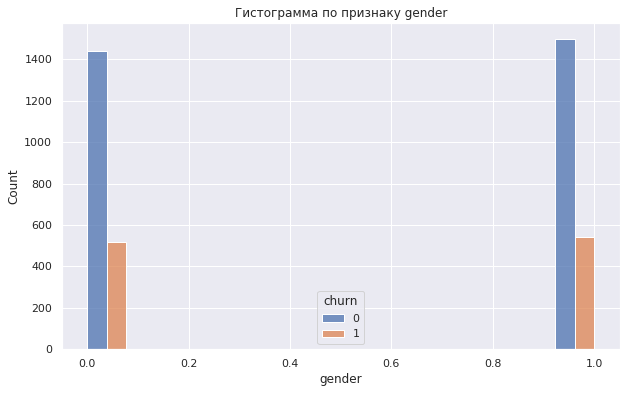

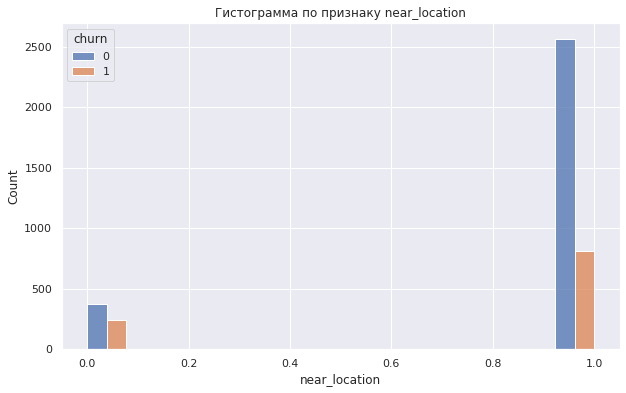

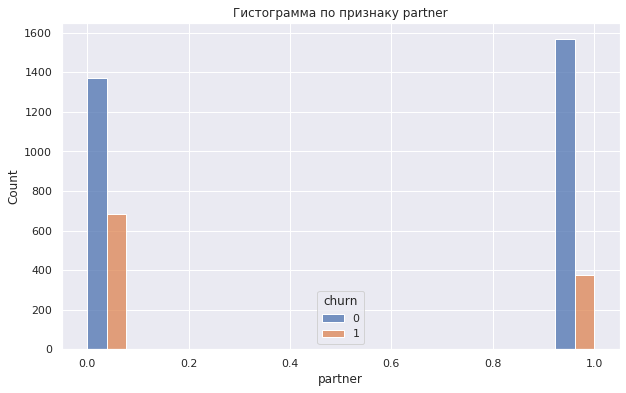

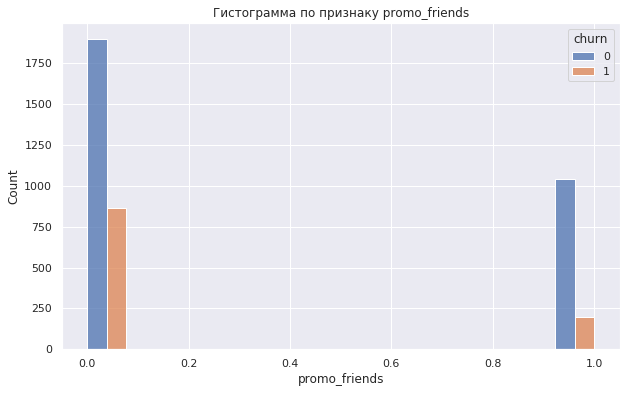

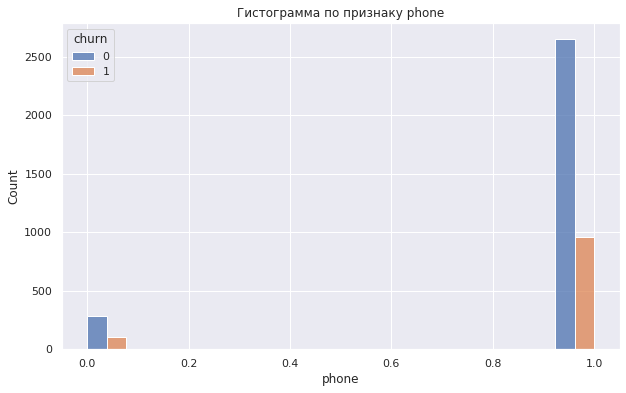

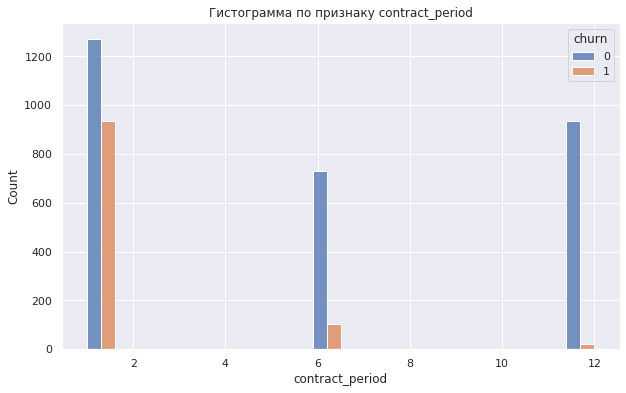

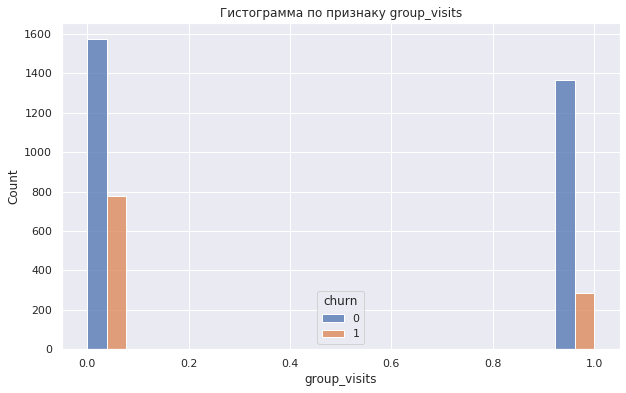

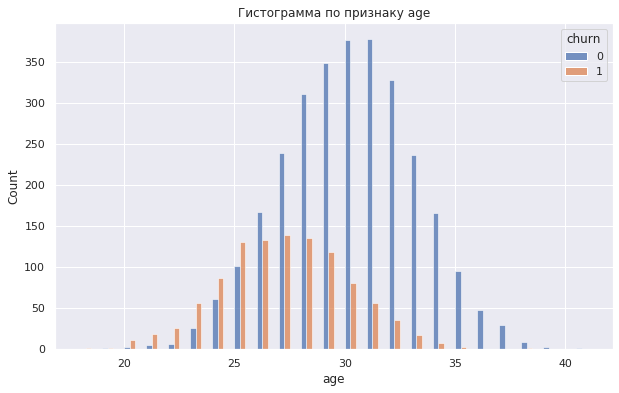

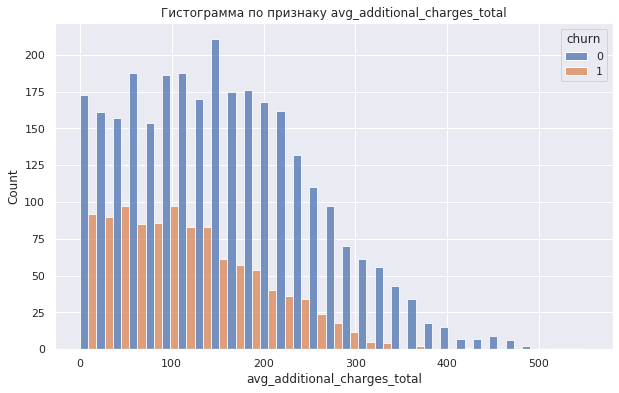

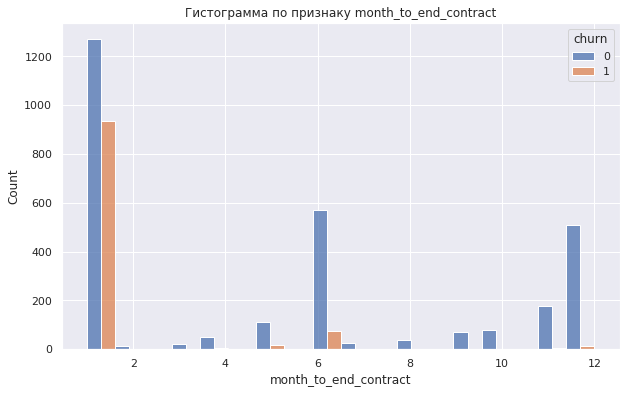

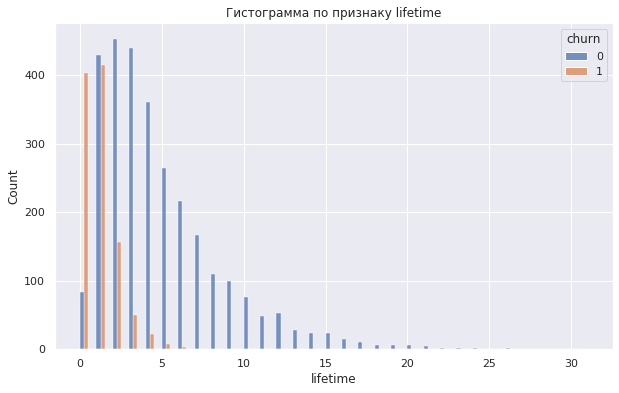

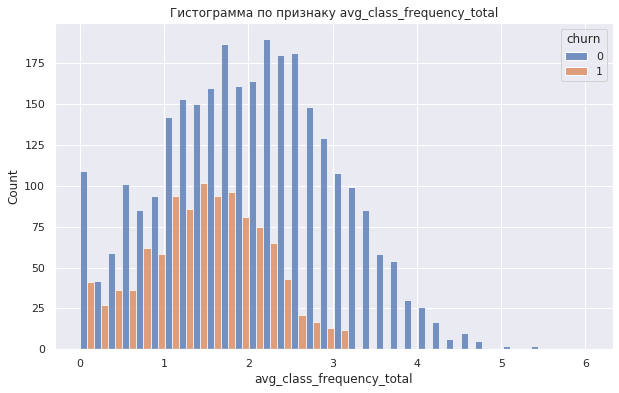

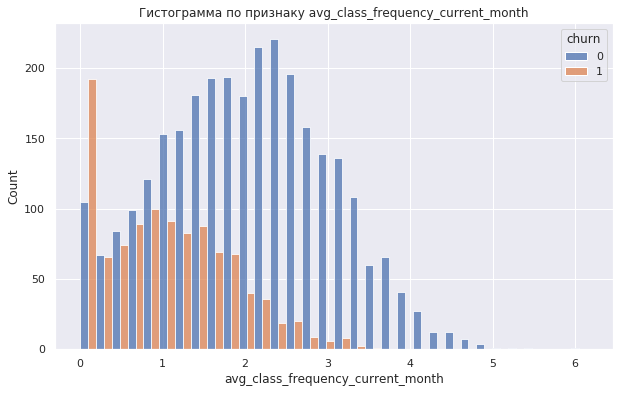

In [7]:
plt.style.use('ggplot')
sns.set_theme()

for i in churn.drop('churn',axis=1).columns:
    plt.figure(figsize=(10,6))
    sns.histplot(churn,x=i,hue='churn',multiple="dodge")
    plt.title("Гистограмма по признаку " + i)
    plt.show()

Дополнительно посмотрим, какие абонементы (1, 6 или 12 месяцев) предпочитают клиенты в зависимости от длительности пользования услугами финтнес-центра. Для этого построим гистограмму, отображающую лайфтайм и количество клиентов в разбивке по типу абонемента.

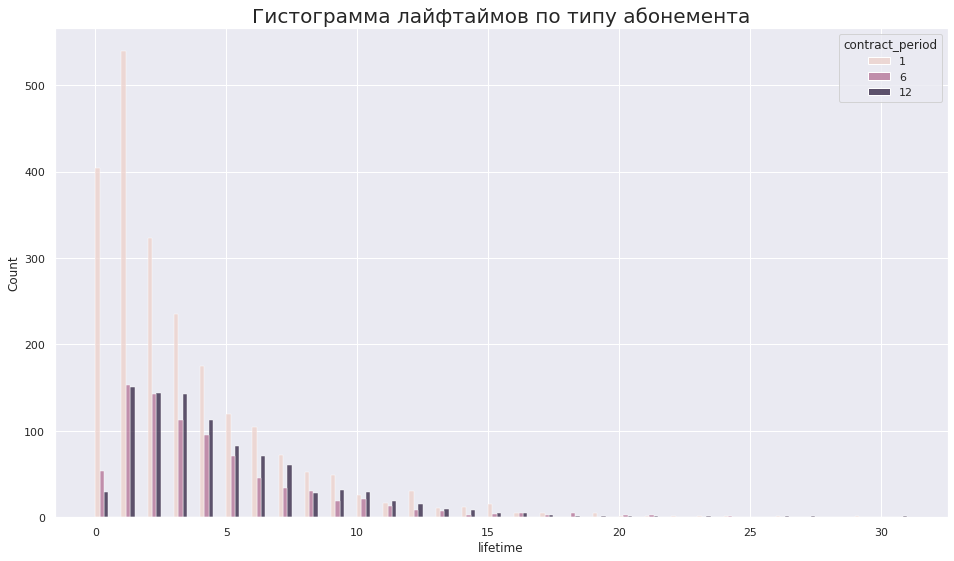

In [8]:
plt.figure(figsize=(16,9))

sns.histplot(churn,x='lifetime',hue='contract_period',multiple="dodge")
plt.title("Гистограмма лайфтаймов по типу абонемента", fontsize=20)
plt.show()

Ожидаемо видим, что новые клиенты в основном предпочитают брать короткий "пробный" абонемент на месяц. С течением времени пользователи начинают активнее покупать более длительные абонементы (те, кто не отвалился после первого месяца). Однако при этом, даже среди клиентов, которые посешают зал уже 10 месяцев всё равно большинство предпочитает короткие абонементы.

Из полученных гистограмм можем сделать следующие выводы:

* Пол клиента никак не влияет на то, уйдет он или нет.
* Среди клиентов, которые не живут и не работают в районе фитнес-центра, процент оттока больше.
* Среди клиентов, у которых есть скидка от работодателя, процент оттока меньше.
* Те, кого привели друзья, уходят реже.
* Подавляющее большинство ушедших - обладатели самого короткого абонимента (1 месяц)
* Среди тех, кто посещал групповые занятия, отток меньше.
* Среди людей старше 35 лет, процент оттока почти нулевой. Видимо взрослые люди более взвешенно принимают решения.
* Среди тех, кто тратит от 100 до 150 денег на доп. услуги процент оттока больше, чем среди тратящих 150 - 350. Тех, кто тратит больше немного, зато они вообще не уходят.
* Больше всего ушедших среди тех, у кого осталось не больше месяца до конца абонемента.
* Самый большой процент оттока среди новых клиентов, обратившихся не более 2 месяцев назад. Если клиент продолжил пользоваться услугами центра более 3 месяцев, скорее всего он не уйдет.
* Среди клиентов, в среднем посещавших центр более 2 раз в неделю, отток ниже.
* Самое большое количество ушедших, те кто ни разу не посетил центр в предыдущий месяц.

Построим матрицу корреляций и визализируем её, чтобы узнать, если ли у нас признаки, сильно коррелирующие друг с другом.

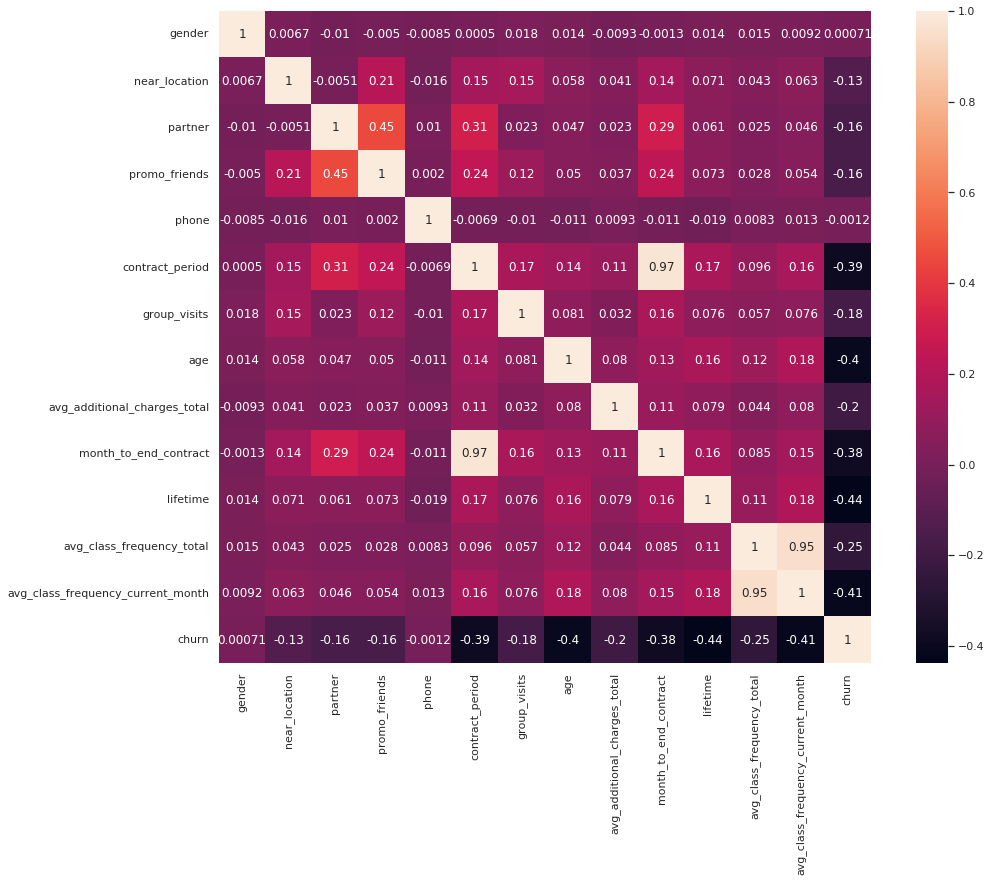

In [9]:
# матрица корреляций
cm = churn.corr()

# строим heatmap
plt.figure(figsize=(16,12))
sns.heatmap(cm,annot=True,square=True)
plt.show()

Очевидно сильно коррелируют между собой *средняя частота посещений в неделю за предыдущий месяц* и  *средняя частота посещений в неделю за все время с начала действия абонемента*. А также *длительность абонемета* и *число месяцев до окончания абонемента*. Корреляция признаков не должна сильно повлиять на работу алгоритмов, которые мы собираемся использовать (логистическая регрессия и случайный лес), поэтому удалять коррелирующие признаки не будем.

**Вывод:**

Из проведенного анализа можем сделать вывод, что группу риска представляют прежде всего новые клиенты, решившие начать новую жизнь не более месяца назад. Как правило, они покупают "пробный" абонемент на месяц, после которого значительная часть уходит. Также на параметр оттока влияет посещение групповых занятий и то, пришел клиент по рекомендации друга или нет. Видимо, социальная часть тоже важна.

## Модель прогнозирования оттока клиентов

Перед построением моделей сохраним отдельно матрицу признаков Х и значения целевой переменной у.

In [10]:
# матрица признаков Х
X = churn.drop('churn',axis=1)
# значения целевой переменной
y = churn['churn']

Разделим модель на обучающую и валидационную выборку в соотношении 80/20%.

In [11]:
# разделим модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Создадим функцию, выводящую значения метрик accuracy, precision, recall, f1 и roc auc:

In [12]:
def print_all_metrics(y_true, y_pred, y_proba, title):
    print(title)
    print('Accuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('Precision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('Recall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('F1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

Всё готово, можем строить модели. Для алгоритмов логистической регрессии и случайного леса стандартизировать признаки необязательно, поэтому не будем этого делать. 

### Логистическая регрессия

Обучим модель методом логистической регрессии:

In [13]:
# задаем алгоритм для модели
lr_model = LogisticRegression(solver='liblinear')

# обучим модель
lr_model.fit(X_train,y_train)

# делаем прогнозы
lr_predictions = lr_model.predict(X_test)
lr_probabilities = lr_model.predict_proba(X_test)[:,1]

print_all_metrics(y_test,
                  lr_predictions,
                  lr_probabilities,
                  'Метрики для модели логистической регрессии')

Метрики для модели логистической регрессии
Accuracy: 0.93
Precision: 0.86
Recall: 0.83
F1: 0.85
ROC_AUC: 0.97


Дополнительно посмотрим матрицу ошибок:

In [14]:
lr_cm = confusion_matrix(y_test,lr_predictions)
lr_cm

array([[576,  26],
       [ 34, 164]])

Доля правильных ответов Accuracy составляет 93%, однако в нашем случае классы неравны, ведь клиентов ушедших в отток меньше, чем тех, кто продолжает исправно посещать зал, поэтому не будем ориентироваться только на эту метрику. Скорее всего, в нашем случае имеет смысл больше ориентироваться на Recall, ведь нам важнее выловить клиентов, которые действительно собрались уходить и лучше перестраховаться, чем допустить отток клиентов. Recall также имеет довольно высокое значение - 83%.
Метрика ROC_AUC тоже имеет хорошее значение - 97%, это говорит о том, что модель хорошо выделяет классы клиентов по вероятности оттока.

Выведем коэффициенты регрессии, чтобы оценить важность признаков:

In [15]:
feature_weights = pd.DataFrame({'feature':X_train.columns,'weights':lr_model.coef_[0]})
display(feature_weights.sort_values(by='weights',ascending=False))

,feature,weights
11,avg_class_frequency_total,3.470850
4,phone,0.611301
1,near_location,0.052976
0,gender,0.047777
8,avg_additional_charges_total,-0.004676
2,partner,-0.048439
9,month_to_end_contract,-0.066940
7,age,-0.181963
5,contract_period,-0.188969
3,promo_friends,-0.568434


По модулям самые большие коэффициенты у признаков **avg_class_frequency_total**(частота посещений в неделю за всё время), **avg_class_frequency_current_month** (частота посещений в неделю за месяц), **lifetime**(кол-во месяцев с первого обращения) и **group_visits**(посещение групповых занятий). Следовательно, модель посчитала эти признаки самыми важными для прогнозирования оттока.

### Случайный лес

Теперь обучим модель методом случайного леса и сравним результаты.

In [16]:
# зададим алгоритм для модели 
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 

# обучим модель случайного леса
rf_model.fit(X_train, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:, 1]


# выведем все метрики
print_all_metrics(y_test,
                  rf_predictions,
                  rf_probabilities, 
                  'Метрики для модели случайного леса')

Метрики для модели случайного леса
Accuracy: 0.92
Precision: 0.84
Recall: 0.82
F1: 0.83
ROC_AUC: 0.97


Результаты в целом схожи с логистической регрессией, однако можно сказать, что случайный лес отработал чуть хуже.

Оценим важность признаков:

In [17]:
# создадим датафрейм с именами признаков и их важностью и выведем его по убыванию важности
features = pd.DataFrame({'feature':X_train.columns,'importances':rf_model.feature_importances_})
print(features.sort_values(by='importances',ascending=False))

                              feature  importances
10                           lifetime     0.276499
12  avg_class_frequency_current_month     0.180170
11          avg_class_frequency_total     0.129883
7                                 age     0.119129
8        avg_additional_charges_total     0.091473
9               month_to_end_contract     0.068855
5                     contract_period     0.065964
6                        group_visits     0.015652
0                              gender     0.012425
2                             partner     0.012285
3                       promo_friends     0.012053
1                       near_location     0.009421
4                               phone     0.006192


Самыми важными признаками по версии этой модели также являются lifetime, avg_class_frequency_current_month и avg_class_frequency_total, только на 4м месте вместо группых занятий теперь возраст клиента. 

**Вывод:**
Обе модели показали хорошие результаты, однако логистическая регрессия показала себя чуть лучше. По результатам работы обеих моделей можем выделить самые главные признаки, влияющие на отток клиентов:

* lifetime (кол-во месяцев с первого обращения)
* avg_class_frequency_current_month (частота посещений в неделю за месяц)
* avg_class_frequency_total (частота посещений в неделю за всё время)
* age (возраст)
* group_visits (посещение групповых занятий)

## Кластеризация клиентов

Кластеризация относится к обучению без учителя, значит учитывать столбец churn не будем.

Перед кластеризацией необходимо стандартизировать признаки:

In [18]:
# стандартизация данных 
sc = StandardScaler()
X_sc = sc.fit_transform(X)

Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму:

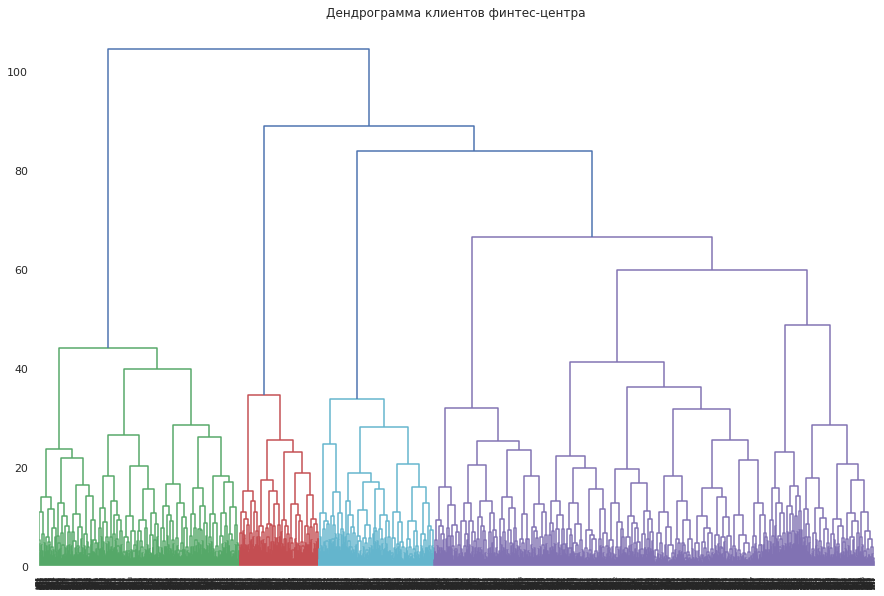

In [19]:
# матрица расстояний
linked = linkage(X_sc, method = 'ward')

# дендрограмма
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title("Дендрограмма клиентов финтес-центра")
plt.show() 

Предложенное оптимальное число классов 4. Однако из дендрограммы видно, что один из классов получился значительно больше остальных, и разброс пользователей по признакам в нём скорее всего будет велик, поэтому выделим не 4, а 5 классов.

Проведем кластеризацию методом KMeans.

In [20]:
# задаём модель k_means с числом кластеров 5
km = KMeans(n_clusters = 5, random_state=0)
# прогнозируем кластеры для наблюдений
labels = km.fit_predict(X_sc)

# добавим кластерную разметку в таблицу
churn['cluster_km'] = labels

# группируем данные по кластерам и смотрим средние значения признаков:
cluster_churn = churn.groupby('cluster_km').mean()
display(cluster_churn)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.502473,0.959446,0.783383,0.574679,1.000000,10.884273,0.543027,29.980218,160.706969,9.950544,4.738872,1.983305,1.976225,0.027695
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.560335,0.976105,0.356033,0.229391,0.998805,2.665472,0.473118,30.127838,161.724258,2.455197,4.896057,2.851531,2.849473,0.068100


Явно выделяется класс 0, это наименее проблемные клиенты, обладатели абонементов на 12 месяцев, тратящие больше всего денег на доп. услуги, среди них большой процент тех, кто имеет скидки от работы. Эти клиенты давно пользуются услугами центра - в среднем 5 месяцев, а также в среднем регулярно посещают центр 2 раза в неделю. Доля оттока среди них минимальна.

Класс 4 похож на класс 0, но эти пользователи предпочитают брать короткие абонементы на месяц. Доля оттока среди них тоже незначительная.

Наиболее проблемный класс - 3, клиенты с максимальной долей оттока. У них нет скидок от работы, почти никто не пришел по рекомендации друзей, абонементы они берут в основном на месяц, средний возраст самый маленький, денег тратят меньше всех, посещают центр тоже реже, чем остальные.

Класс 2 тоже проблемный, в нем находятся пользователи, которые не живут и не работают рядом с фитнес-центром, они также не пришли по рекомендации друзей и меньше всех посещают групповые занятия. Возможно, это как раз те, которым становится скучно одиноко бегать на дорожке, и они уходят.

Класс 1 ничем особо не выделяется, средний по всем признаков, доля оттока тоже средняя.

Построим графики и детальнее рассмотрим выделенные кластеры:

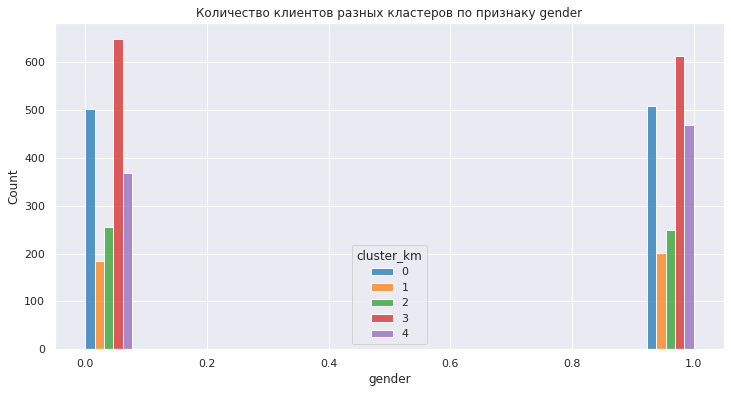

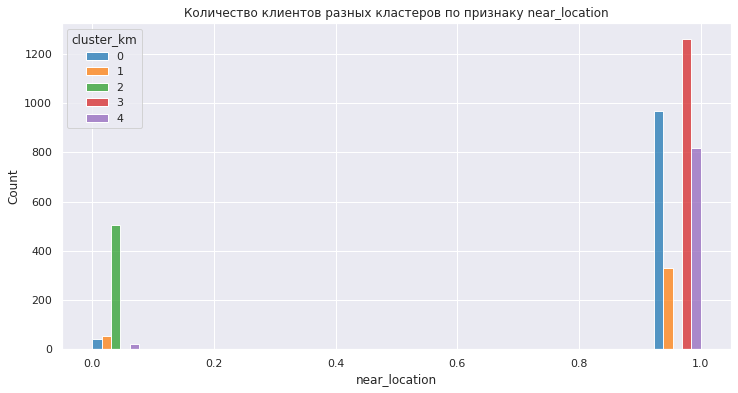

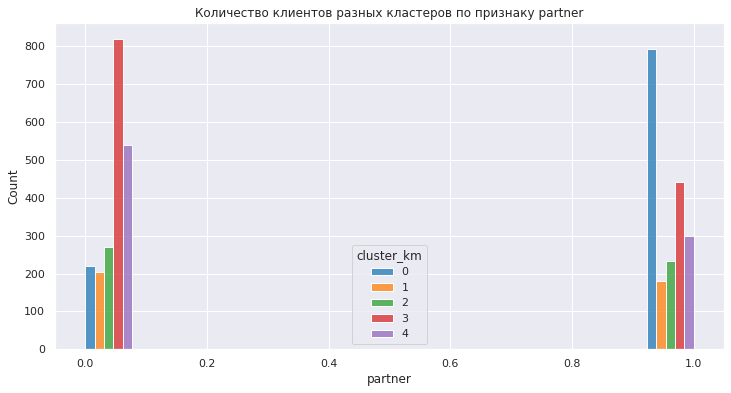

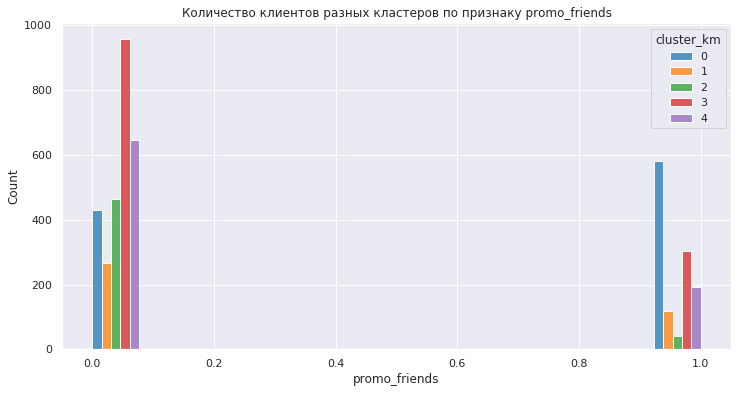

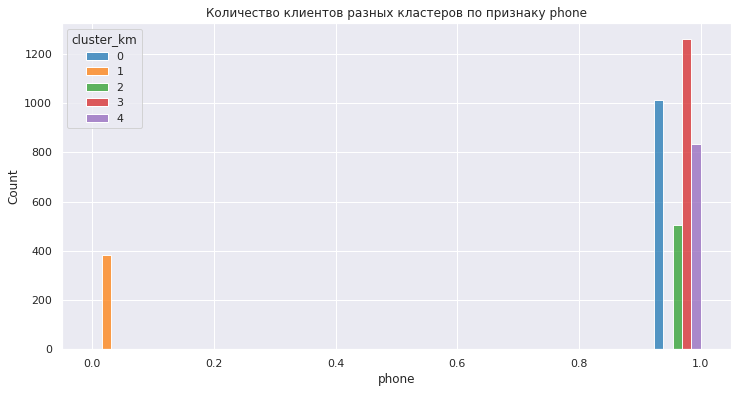

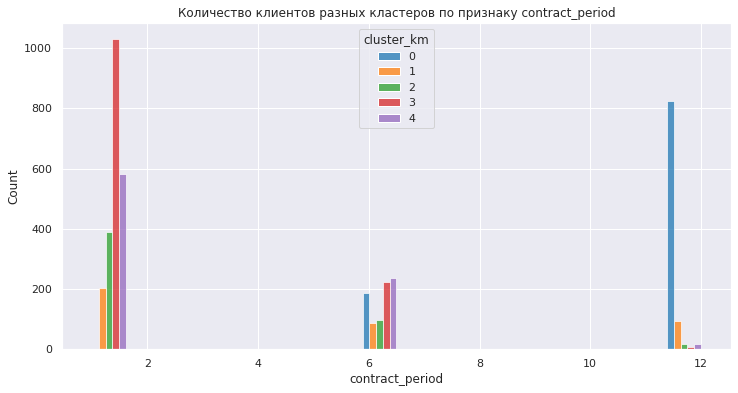

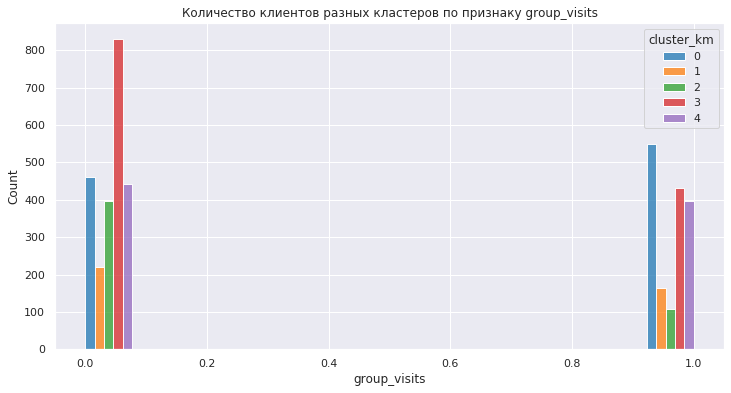

In [21]:
for i in churn.columns[0:7]:
    plt.figure(figsize=(12,6))
    sns.histplot(x=i,data=churn,hue='cluster_km',multiple="dodge",palette="tab10")
    plt.title("Количество клиентов разных кластеров по признаку " + i)
    plt.show()

Из интересного, подверждаем, что только клиенты класса 2 не живут рядом с фитнес-центром, почти все клиенты класса 3 пришли не по рекомендации друзей и не по партнерской программе, также клиенты класса 3 покупают в основном короткие абонементы, а клиенты класса 0 только длинные на 12 месяцев. Клиенты класса 3 реже всех посещают групповые занятия.

Построим гистограммы для количественных признаков:

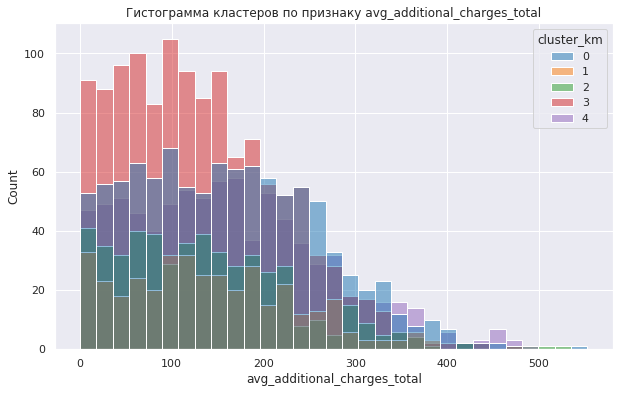

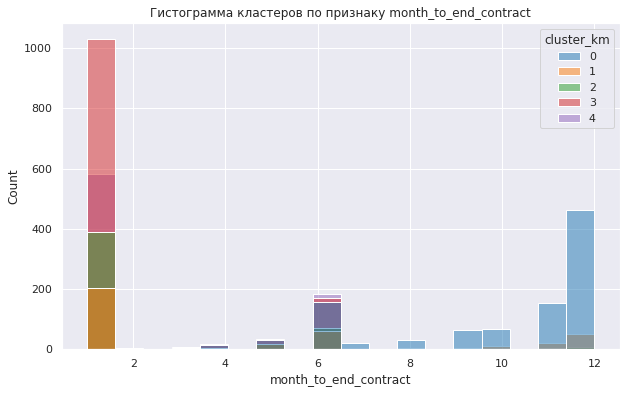

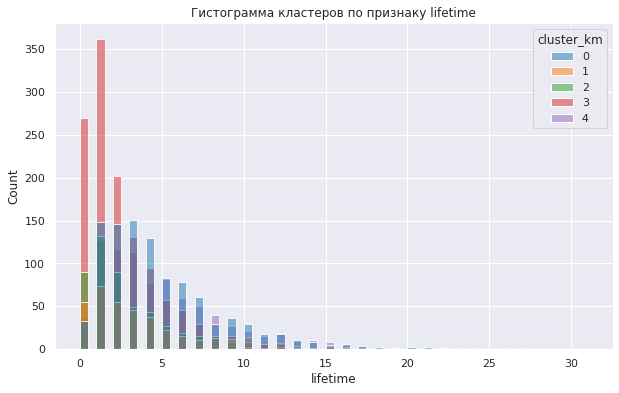

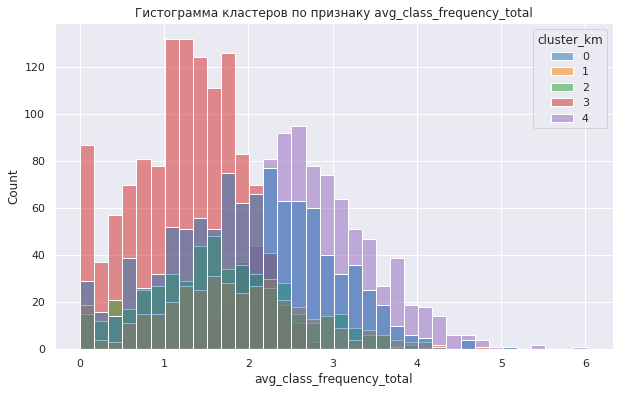

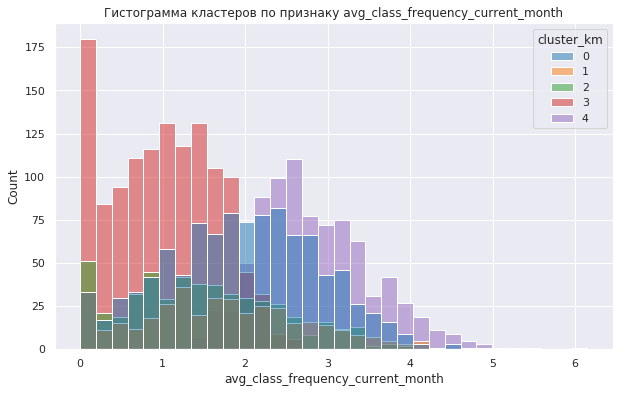

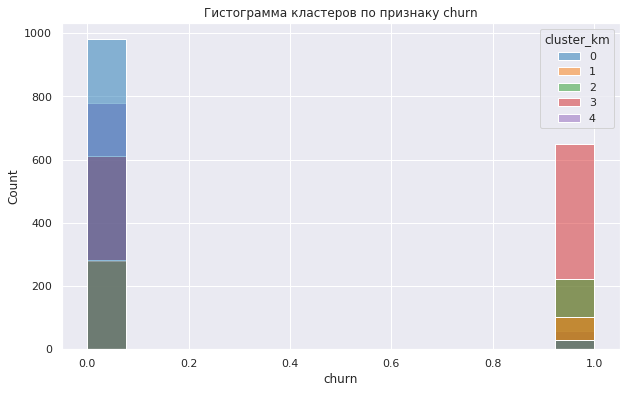

In [22]:
for i in churn.columns[8:14]:
    sns.set_style("darkgrid")
    plt.figure(figsize=(10,6))
    sns.histplot(churn,x=i,hue='cluster_km', palette="tab10")
    plt.title("Гистограмма кластеров по признаку " + i)
    plt.show()

Почти у всех клиентов класса 3 абонемент подходит к концу, но это не удивительно, мы уже выяснили, что почти все они берут короткие абонементы на месяц. У клиентов группы 0 до конца абонемента еще долго. Клиенты класса 3 самые свежие. Группа 3 и 2 посещают зал реже (0-2 раза в неделю), 0 и 4 чаще - 2-5 раза в неделю.

Ещё раз посмотрим на долю оттока:

In [23]:
cluster_churn['churn'].sort_values(ascending=False)

cluster_km
3    0.514263
2    0.443564
1    0.267532
4    0.068100
0    0.027695
Name: churn, dtype: float64

В итоге получается, что классы 0 и 4 - надежные, 2 и 3 - ненадежные, 1 - средний.

**Вывод:**

После класстеризации удалось выделить 5 основных групп клиентов фитнес-центра:

0 - *надежный*. Старые проверенные клиенты с самыми длинными абонементами. Тратят больше всего денег на доп.услуги. Многие пришли по партнерской пограмме. Самая маленькая вероятность оттока.

1 - средний клиент, никаких выдающихся признаков, исправно ходит на тренировки. Показатель оттока тоже средний.

2 - *ненадежный*, здесь у нас люди, которые не живут и не работают рядом с фитнес-центром, пришли не по рекомендации друзей и в основном не ходят на групповые занятия. Предпочитают короткие абонементы, посещают центр не больше 2 раз в неделю. Высокая вероятность оттока.

3 - *ненадежный*. Пришли не по партнерским скидкам и не по рекомендации друзей, почти все берут короткие месячные абонементы, не пользуются доп. услугами и мало ходят на групповые занятия. Скорее всего, новички, которые решили попробовать "начать жизнь с понедельника". Самая большая вероятность оттока.

4 - *надежный*. Также предпочитают короткие абонементы, но при этом регулярно посещают центр больше 2 раз в неделю, и в обсновном являются клиентами центра продолжительное время (самые большие показатели lifetime). Видимо, достаточно замотивированные люди, которым по каким-то причинам неудобно брать длительный абонемент.

## Общий вывод

В ходе проекта было испробовано 2 варианта моделей, способных успешно прогнозировать отток клиентов. Были использованы алгоритмы логистической регрессии и случайного леса. Обе модели проявили себя достаточно хорошо, однако по результатам метрик **логистическая регрессия** справилась чуть лучше (Accuracy - 93%, Precision - 86%, Recall - 83%).

Также после обучения моделей появлилась возможность точно сказать, какие **признаки** с наибольшей вероятностью влияют на отток:

* lifetime (кол-во месяцев с первого обращения)
* avg_class_frequency_current_month (частота посещений в неделю за месяц)
* avg_class_frequency_total (частота посещений в неделю за всё время)
* age (возраст)
* group_visits (посещение групповых занятий)

С помощью кластеризации удалось выделить **5 основных групп клиентов**:

* 0 - надежный. Старые проверенные клиенты. Ходят на тренировки больше 2 раз в неделю, покупают самые длительные абонементы. С ними проблем нет, вероятность оттока минимальна.
* 1 - средний клиент, никаких выдающихся признаков, исправно ходит на тренировки. Показатель оттока тоже средний.
* 2 - ненадежный. Главная особенность - не живут и не работают рядом с фитнес-центром. Покупают в основном короткие абонементы, посещают центр не чаще 2 раз в неделю. Высокая вероятность оттока. 
* 3 - ненадежный. Самая ненадежная группа, предположительно новички, только окунувшиеся в мир спорта и купившие абонемент на месяц "попробовать". Тратят меньше всех на доп. услуги, посещаемость слабая (не больше 2 раз в неделю). Самая большая вероятность оттока.
* 4 - надежный. Хорошие замотивированные клиенты, регулярно и много ходят на тренировки. Их отличительная особенность - покупают только короткие абонементы на 1 месяц. Скорее всего, так им удобнее в связи с рабочим графиком.

Таким образом у нас есть 2 проблемные группы - 2 и 3.
Скорее всего, для группы 2 основной фактор оттока - неудобное расположение фитнес-центра (они все живут и работают далеко от него). Вряд ли на это можно сильно повлиять, однако такого клиента стоит уведомить, если откроется филиал ближе к его дому (если есть такая информация). Также эти клиенты плохо вовлечены в социальную часть процесса, они пришли не по рекомендации друга и не посещают групповые занятия. Стоит попробовать приобщить их групповым тренировкам, чтобы они не заскучали. Как вариант, можно проводить какие-нибудь специальные мероприятия, например, марафоны. 

В группе 3 отток больше всего. Предположительно, это новички, не успевшие зацепиться. В целом, это нормально, в любом бизнесе есть такие клиенты. Если мы хотим конвертировать их в постоянных клиентов, возможно, имеет смысл ввести какие-нибудь специализированные недлинные программы, во время которых клиент втянется в процесс, и в дальнейшем может продолжить тренероваться уже самостоятельно.
